In [1]:
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import pandas as pd

from collections import Counter

import re

import string

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

from gensim.models import Word2Vec
import gensim

from sklearn.manifold import TSNE

import pickle

In [2]:
location = './twitter_data/train2017.tsv'
df = pd.read_csv(location , sep="\t" , header = None)

In [3]:
ndf = df.head(10) #takes the first x entries

dl = ndf.values.tolist()

# dl = df.values.tolist()

tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tokens      = []
fusedTokens = []
positives   = []
negatives   = []
neutrals    = []

for item in dl:
    
    tweet = item[3]
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    temp = tknzr.tokenize(tweet)
    
    print(temp)
    
#     temp = [w.lower() for w in temp] #convert to lower case
    
    stop_words = stopwords.words('english')    #sets stop words
    newStopWords = ["i'm" , "he's" , "she's" , "we're" , "you're" , "they're"]
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    
    temp = [w for w in temp if not w in stop_words]  #removes stop words
    
    table = str.maketrans('', '', string.punctuation) #remove punctuation
    temp = [w.translate(table) for w in temp]
    
    temp = [word for word in temp if word.isalpha()] #remove remaining tokens that are not alphabetic
    
#     porter = PorterStemmer() #stemming (not that useful)
#     temp = [porter.stem(word) for word in temp]

    if item[2] == "positive":  #need to give the words positive and negative weight so that the most common words in positive posts is not "tomorrow"
        positives.extend(temp)
    elif item[2] == "negative":
        negatives.extend(temp);
    elif item[2] == "neutral":
        neutrals.extend(temp)
        
    fusedTokens.extend(temp)
    tokens.append(temp)
    
print("\n")
print(tokens)
print("\n")
print(fusedTokens)

['gas', 'by', 'my', 'house', 'hit', '.', '39', '!', '!', '!', "i'm", 'going', 'to', 'chapel', 'hill', 'on', 'sat', '.', ':)']
['theo', 'walcott', 'is', 'still', 'shit', ',', 'watch', 'rafa', 'and', 'johnny', 'deal', 'with', 'him', 'on', 'saturday', '.']
['its', 'not', 'that', "i'm", 'a', 'gsp', 'fan', ',', 'i', 'just', 'hate', 'nick', 'diaz', '.', "can't", 'wait', 'for', 'february', '.']
['iranian', 'general', 'says', "israel's", 'iron', 'dome', "can't", 'deal', 'with', 'their', 'missiles', '(', 'keep', 'talking', 'like', 'that', 'and', 'we', 'may', 'end', 'up', 'finding', 'out', ')']
['tehran', ',', 'mon', 'amour', ':', 'obama', 'tried', 'to', 'establish', 'ties', 'with', 'the', 'mullahs']
['i', 'sat', 'through', 'this', 'whole', 'movie', 'just', 'for', 'harry', 'and', 'ron', 'at', 'christmas', '.', 'ohlawd']
['with', 'j', 'davlar', '11th', '.', 'main', 'rivals', 'are', 'team', 'poland', '.', 'hopefully', 'we', 'an', 'make', 'it', 'a', 'successful', 'end', 'to', 'a', 'tough', 'week', 

In [4]:
count = Counter(fusedTokens)
print("Generally most common words : " , count.most_common(10))

count = Counter(positives)
print("Most common words found in positive posts : " , count.most_common(10))

count = Counter(negatives)
print("Most common words found in negative posts : " , count.most_common(10))

count = Counter(neutrals)
print("Most common words found in neutral posts : " , count.most_common(10))

Generally most common words :  [('sat', 2), ('deal', 2), ('cant', 2), ('february', 2), ('talking', 2), ('may', 2), ('end', 2), ('college', 2), ('superbowl', 2), ('dallas', 2)]
Most common words found in positive posts :  [('gas', 1), ('house', 1), ('hit', 1), ('going', 1), ('chapel', 1), ('hill', 1), ('sat', 1), ('j', 1), ('davlar', 1), ('main', 1)]
Most common words found in negative posts :  [('deal', 2), ('cant', 2), ('talking', 2), ('may', 2), ('college', 2), ('superbowl', 2), ('dallas', 2), ('theo', 1), ('walcott', 1), ('still', 1)]
Most common words found in neutral posts :  [('tehran', 1), ('mon', 1), ('amour', 1), ('obama', 1), ('tried', 1), ('establish', 1), ('ties', 1), ('mullahs', 1), ('sat', 1), ('whole', 1)]


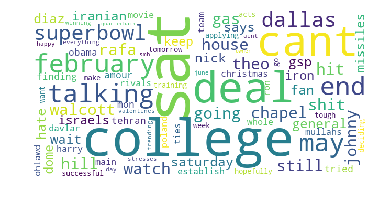

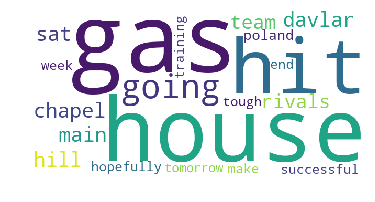

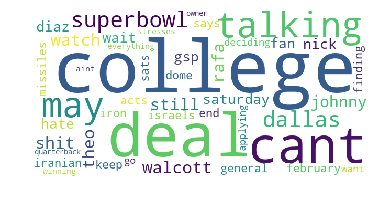

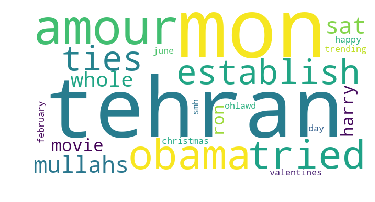

In [5]:
final = ""
for word in fusedTokens:
    final += " " + word
    
wc = WordCloud(background_color="white" , width=640 , height=320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

final = ""
for word in positives:
    final += " " + word
    
wc = WordCloud(background_color="white" , width=640 , height=320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

final = ""
for word in negatives:
    final += " " + word
    
wc = WordCloud(background_color="white" , width=640 , height=320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

final = ""
for word in neutrals:
    final += " " + word
    
wc = WordCloud(background_color="white" , width=640 , height=320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

Generally we can see that words like "love" appear in positive posts as expected , whereas "positive" words like "like" appear in negative posts . Also there are many neutral words like "tomorrow" that have the same distribution in both positive and negative posts.

In [11]:
newTokens = []
for item in tokens:
    final = ""
    for word in item:
        final += " " + word
    
    newTokens.append(final)
    
# bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=100, stop_words='english')
bow_vectorizer = CountVectorizer(max_features=100) 
bow_xtrain = bow_vectorizer.fit_transform(newTokens)  #TWEETS : a list with the actual tweets 
# print(bow_vectorizer.get_feature_names())
# print(bow_xtrain.toarray())
print(bow_xtrain.shape)  #the output is a numpy array of features. The dimensionality of this array depends on the number of TWEETS (shape should be number_of_tweets x vocabulary_size) 


filename = "bow.pkl"
outfile = open(filename , "wb")
pickle.dump(bow_xtrain , outfile)
outfile.close()

(10, 85)


In [12]:
# tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english') 
tfidf_vectorizer = TfidfVectorizer(max_features=100) 
tfidf = tfidf_vectorizer.fit_transform(newTokens)
print( tfidf.shape) #the output is a numpy array of features


filename = "tfidf.pkl"
outfile = open(filename , "wb")
pickle.dump(bow_xtrain , outfile)
outfile.close()

(10, 85)


In [16]:
# tokenized_tweet = tweets.apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokens,
            size=10, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokens, total_examples= len(tokens), epochs=20)


filename = "wordEmbs.pkl"
outfile = open(filename , "wb")
pickle.dump(bow_xtrain , outfile)
outfile.close()

In [20]:
# model_w2v.wv.most_similar(positive="college")
model_w2v.wv.__getitem__("college")

array([-0.02001589,  0.02200056,  0.03541158,  0.01609194, -0.01505624,
        0.00325105,  0.03382789,  0.0293923 , -0.01106613,  0.03027713],
      dtype=float32)

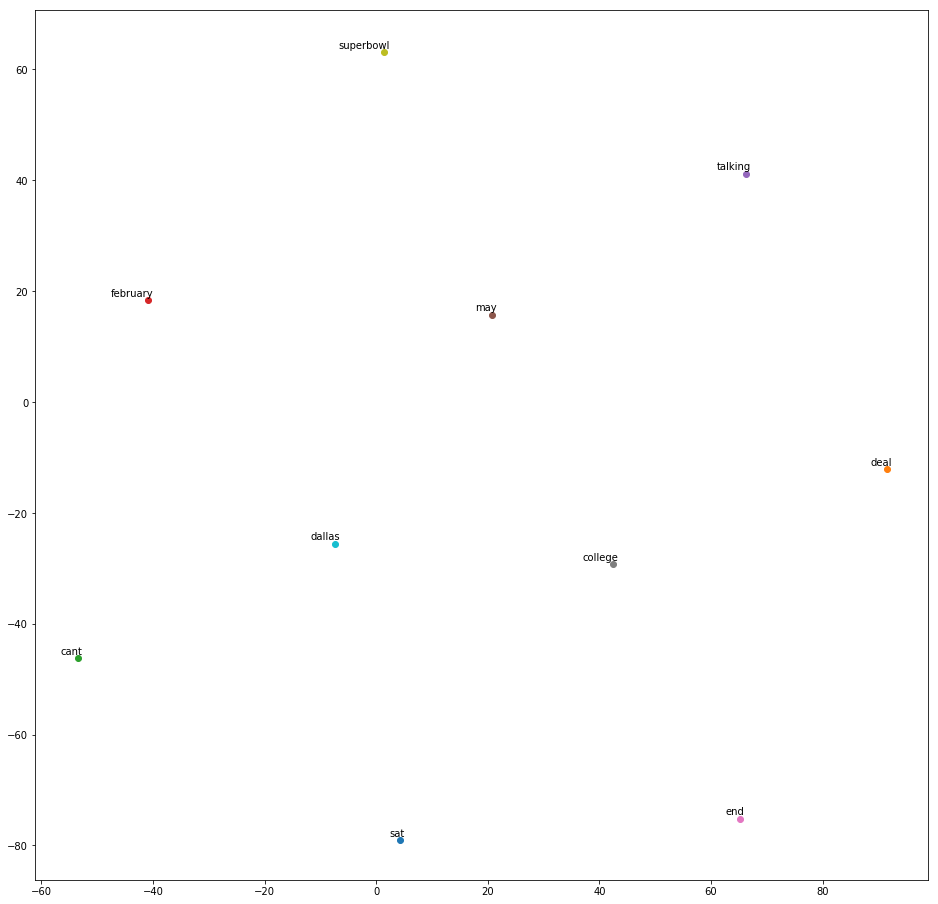

In [15]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model.wv.__getitem__(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
               textcoords='offset points',
                         ha='right',
                         va='bottom')
    plt.show()


tsne_plot(model_w2v)